# An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale

[Vision Transformer, ViT](https://arxiv.org/abs/2010.11929) proposed in 2020, gaps the bridge of model architecture between CV and NLP. We implemented ViT on our own and did some experiment and exploration here.

This Notebook is organized as follows:
- trained a tiny vision transfomer image classifier from scratch on cifar10/tiny-imagenet200
- visualized the attention map
- showed the ViT receptive field area of each head across layers 

In [1]:
import torch
import einops
import numpy as np
import matplotlib.pyplot as plt

from paperlab.zoo import vit
from paperlab.core import Config
from torch.utils.data import Subset, DataLoader

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
params = {
    'image_size': (64, 64),
    'patch_size': (4, 4),
    'num_channel': 3,
    'pool': 'cls',
#     'use_dataset': 'tiny-imagenet-200',
#     'num_class': 200 
    'use_dataset': 'cifar10',
    'num_class': 10,

    'transformer.depth': 8,
    'transformer.dim': 128,
    'transformer.dropout': 0.1,
    'transformer.emb_dropout': 0.,
    'transformer.num_head': 4,
    'transformer.dim_head': 64,
    'transformer.dim_mlp': 128,

    'learning.batch_size': 20,
    'learning.lr': 5e-4,
    'learning.num_epoch': 200,
    'learning.early_stop_patience': 10,
    
    'display_freq': 2500,
    'validate_freq': 20000,
}

config = Config(**params)

For simplicity, we will train a 8-layer-4-head Vit model using the CIFAR10 dataset from scratch here rather than using the pre-train and fintune padadigm described in the paper.

In [ ]:
model, stats = vit.train(config)

number of model parameter: 1358474
Adjusting learning rate of group 0 to 5.0000e-04.
Files already downloaded and verified
Files already downloaded and verified
Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

step-2500: training_loss: 1.8961
Adjusting learning rate of group 0 to 5.0000e-04.
step-5000: training_loss: 1.8934
Adjusting learning rate of group 0 to 5.0000e-04.
step-7500: training_loss: 1.8370
Adjusting learning rate of group 0 to 5.0000e-04.
step-10000: training_loss: 1.6405
Adjusting learning rate of group 0 to 5.0000e-04.
step-12500: training_loss: 1.6370
Adjusting learning rate of group 0 to 5.0000e-04.
step-15000: training_loss: 1.5895
Adjusting learning rate of group 0 to 5.0000e-04.
step-17500: training_loss: 1.5786
Adjusting learning rate of group 0 to 5.0000e-04.
step-20000: training_loss: 1.3477


Text(0.5, 0, 'step')

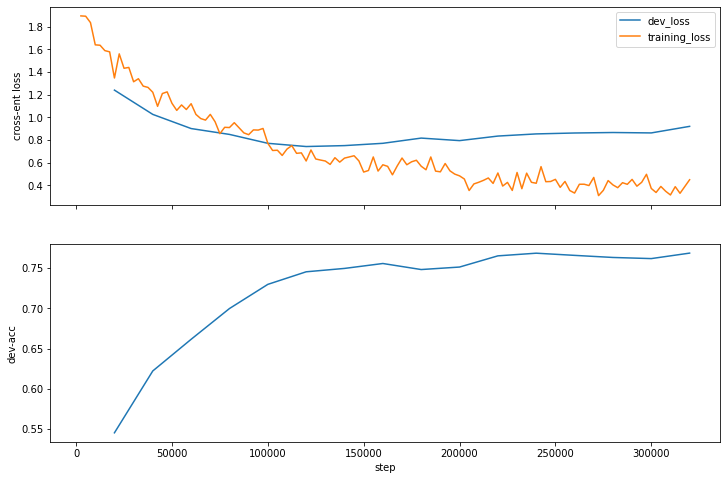

In [8]:
fig, ax = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

ax[0].plot(stats['dev_loss'].keys(), stats['dev_loss'].values(), label='dev_loss')
ax[0].plot(stats['training_loss'].keys(), stats['training_loss'].values(), label='training_loss')
ax[0].legend()
ax[0].set_ylabel('cross-ent loss')

ax[1].plot(stats['dev_acc'].keys(), stats['dev_acc'].values())
ax[1].set_ylabel('dev-acc')
ax[1].set_xlabel('step')

We visualize the internal attention map using the [attention rollout](https://arxiv.org/abs/2005.00928) algorithm.

The computation process is as follows:
- get the headwise-averaged attention weight of each layer in the model
- according to *attention rollout*, multiply the averaged attention weight matrix of each layer recursively and get the attention flow each ouput unit at the last layer to each input token at the first layer
- get the attention flow value at the `[CLS]` token, i.e. the comprehensive attention score quried by the `[CLS]` token at the final layer to each image patch token  at the input layer (the `[CLS]` token in input is removed)
- normalize the attention flow (since the `[CLS]`-`[CLS]` query-key pair is removed)

The highlighted area in the image is where the `[CLS]` token places the most attention weight, i.e. where the most valuable information for object detection is provided.

In [9]:
def scale(attn):
    return (attn - attn.min()) / (attn.max() -  attn.min())

Files already downloaded and verified


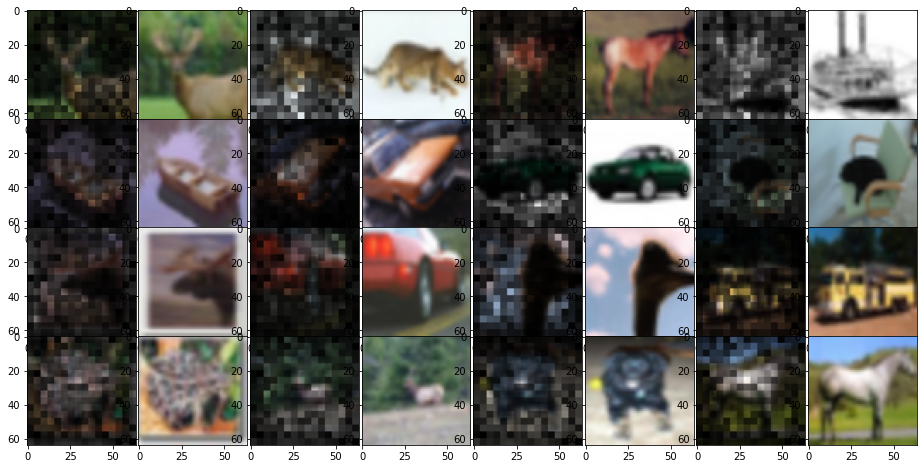

In [10]:
num_row, num_col = 4, 4

val_dataset = vit.get_cifar10('val')
# random sample `num_row * num_col` images from the devset 
sample_indices = np.random.permutation(np.arange(len(val_dataset)))[: num_row * num_col]
sampled_subset = Subset(val_dataset, sample_indices)

# feed the sampled images and get its attention maps
attn_maps, images = vit.get_attention_maps(model, 
                                           DataLoader(sampled_subset, batch_size=config.learning.batch_size))

f, ax = plt.subplots(num_row, num_col * 2, 
                     figsize=(num_row * 4, num_col * 2),
                     gridspec_kw={'wspace': 0, 'hspace': 0}, 
                     squeeze=True)

for i in range(num_row):
    for j in range(num_col):
        attn_map, image = attn_maps[i * num_col], images[i * num_col + j]
        attend_image = scale(torch.unsqueeze(attn_map, 0)) * image
        
        ax[i, 2 * j].imshow(einops.rearrange(attend_image, 'c h w -> h w c').cpu(), aspect=1)  # show image masked with attention
        ax[i, 2 * j + 1].imshow(einops.rearrange(image, 'c h w -> h w c').cpu(), aspect=1)  # show original image

We also show the attention distance of each head across layers. Heads at deeper layer have greater attneiton distance, i.e., larger receptive field, which is simlar to the behaviour of CNN arch. The `mean attention distance` is computed as follows:
- get the attention map of each head at each layer, drop the `[CLS]` token and normalize attention scores among the image patch tokens
- compute the attention score among pixels, i.e. the raw attention value of the patch divided by its pixel number 
- compute the mean euclidean distance between any two pixel, weighted by the pixel attention score
- get average value of attention distance over sampled images

Text(0, 0.5, 'mean attention distance (pixels)')

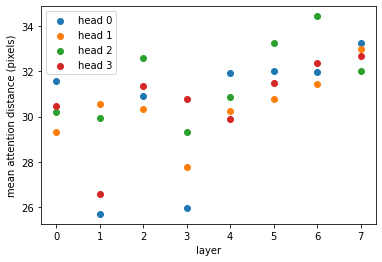

In [11]:
N = 128
sample_indices = np.random.permutation(np.arange(len(val_dataset)))[: N]
sampled_subset = Subset(val_dataset, sample_indices)

attn_distance = vit.get_attention_distance(model, 
                                           DataLoader(sampled_subset, batch_size=config.learning.batch_size))

for head in range(config.transformer.num_head):
    dist_by_layer = attn_distance[:, head].cpu()
    plt.scatter(range(config.transformer.depth), dist_by_layer, label=f"head {head}")

plt.legend()
plt.xlabel('layer')
plt.ylabel('mean attention distance (pixels)')